In [20]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy.stats as stats
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.gridspec as gridspec
import scipy.stats
from scipy.stats import gaussian_kde


In [21]:
"""Code for creating histograms with curves for PET, VWC, and Precipation for Canton from 2002 - 2025"""

"""Creates a dataframe out of the data with dates, precip, pet, vwc for the columns"""

sdate = '2002-03-01'
edate = '2025-05-31'
lat = 40.77
lon = -81.22

url = f"https://csf-irrigation-api-worker.rcc-acis.workers.dev/vwc/?sdate={sdate}&edate={edate}&lat={lat}&lon={lon}&token=api-4a0607-token"

req = requests.get(url)
data = req.text
# print(data)

data = json.loads(data)
df = pd.DataFrame({
    "date": data["dates"],
    "precip": data["precip"],
    "pet": data["pet"],
    "vwc": data["vwc"]
})
df = df[1::]


In [22]:
""" Creates individual dataframes
    spring: March - May
    summer: june - august
    fall: september - november 
    Puts the dtaes into datetime """

df['date'] = pd.to_datetime(df['date'])
spring = df[(df['date'].dt.month < 6) & (df['date'].dt.month > 2)]
summer = df[(df['date'].dt.month < 9) & (df['date'].dt.month > 5)]
fall = df[(df['date'].dt.month < 11) & (df['date'].dt.month > 8)]
spring['pet'] = spring['pet'].astype(float) * 25.4 #converts to mm
summer['pet'] = summer['pet'].astype(float) * 25.4 #converts to mm
fall['pet'] = fall['pet'].astype(float) * 25.4 #converts to mm

/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_60731/3311252620.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring['pet'] = spring['pet'].astype(float) * 25.4 #converts to mm
/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_60731/3311252620.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer['pet'] = summer['pet'].astype(float) * 25.4 #converts to mm
/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_60731/3311252620.py:13: SettingWithCopyWarning: 
A value is t

In [23]:
"""Sets spring date to the index"""

spring = spring.set_index('date')

In [24]:
""" Creates a spring dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

spring_original = spring.copy()
spring.index = spring.index - pd.to_timedelta((spring.index.dayofweek - 1) % 7, unit='D')
spring_weekly_pet = spring['pet'].groupby(spring.index).sum()
spring_weekly_precip = spring['precip'].groupby(spring.index).sum()
spring_joint_pet_precip = pd.concat([spring_weekly_pet, spring_weekly_precip], axis=1)
spring_joint = pd.concat([spring_joint_pet_precip, spring['vwc']], axis=1)
spring_joint['dates of Monday'] = spring_original.index
spring_weekly = spring_joint[spring_joint['dates of Monday'].dt.dayofweek == 0]
print(spring_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-02-26   2.010142  0.360077  0.29      2002-03-04
2002-03-05   6.473678   0.22995  0.28      2002-03-11
2002-03-12   8.222984  0.730194  0.29      2002-03-18
2002-03-19   5.134594  0.489975  0.29      2002-03-25
2002-03-26   9.632502  1.409851  0.27      2002-04-01
...               ...       ...   ...             ...
2025-04-22  19.310681  0.960144  0.27      2025-04-28
2025-04-29  18.673612   2.45993  0.29      2025-05-05
2025-05-06  21.628125  0.729919  0.18      2025-05-12
2025-05-13  18.980332  0.250046  0.12      2025-05-19
2025-05-20  15.114693  1.390137  0.25      2025-05-26

[315 rows x 4 columns]


In [25]:
"""Cleans up the precip as there was a random outlier"""

spring_weekly_clean = spring_weekly[spring_weekly["precip"] >= 0]


Text(0.5, 0.92, 'Spring')

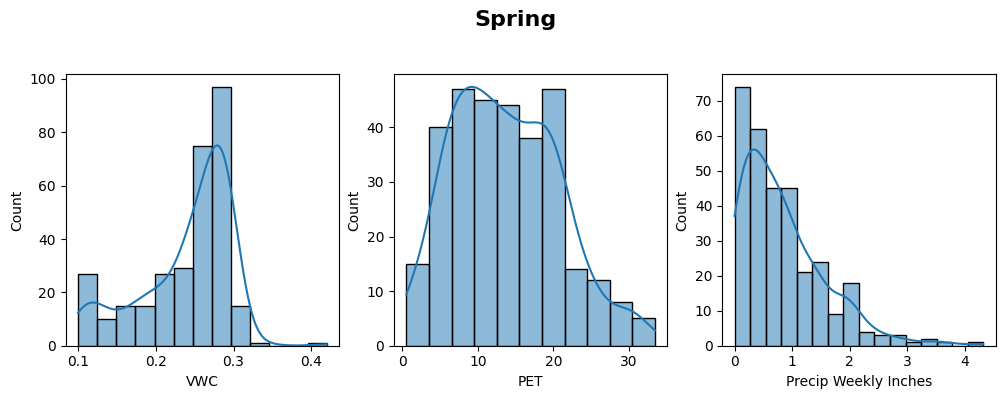

In [26]:
""" Spring:
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(spring_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(spring_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(spring_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Spring', ha='center', fontsize=16, weight='bold')


In [27]:
"""Sets summer date to the index"""

summer = summer.set_index('date')

In [28]:
""" Creates a summer dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

summer_original = summer.copy()
summer.index = summer.index - pd.to_timedelta((summer.index.dayofweek - 1) % 7, unit='D')
summer_weekly_pet = summer['pet'].groupby(summer.index).sum()
summer_weekly_precip = summer['precip'].groupby(summer.index).sum()
summer_joint_pet_precip = pd.concat([summer_weekly_pet, summer_weekly_precip], axis=1)
summer_joint = pd.concat([summer_joint_pet_precip, summer['vwc']], axis=1)
summer_joint['dates of Monday'] = summer_original.index
summer_weekly = summer_joint[summer_joint['dates of Monday'].dt.dayofweek == 0]
print(summer_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-05-28  12.210260      -999   0.1      2002-06-03
2002-06-04  22.478538  3.139893  0.22      2002-06-10
2002-06-11  21.782083  0.969849  0.25      2002-06-17
2002-06-18  32.780681         0   0.1      2002-06-24
2002-06-25  30.843694  0.859863  0.15      2002-07-01
...               ...       ...   ...             ...
2024-07-23  28.485748  0.700035  0.11      2024-07-29
2024-07-30  24.394167  2.760071  0.26      2024-08-05
2024-08-06  22.365364  0.279999  0.16      2024-08-12
2024-08-13  24.547244  1.159828  0.27      2024-08-19
2024-08-20  22.087267         0  0.13      2024-08-26

[302 rows x 4 columns]


In [29]:
"""Cleans up the precip as there was a random outlier"""

summer_weekly_clean = summer_weekly[summer_weekly["precip"] >= 0]
print(summer_weekly[summer_weekly["precip"] < 0])

                  pet precip  vwc dates of Monday
date                                             
2002-05-28  12.210260   -999  0.1      2002-06-03
2007-06-12  31.972167   -999  0.1      2007-06-18


Text(0.5, 0.92, 'Summer')

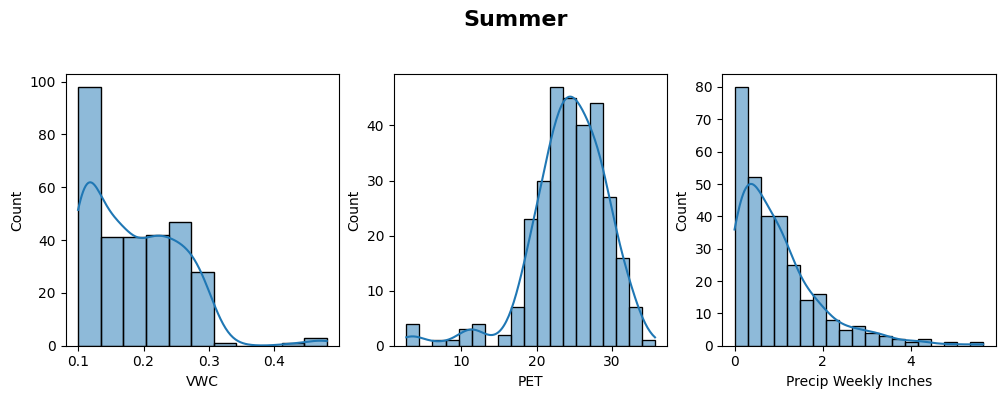

In [30]:
""" Summer: 
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(summer_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(summer_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(summer_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Summer', ha='center', fontsize=16, weight='bold')


In [31]:
"""Sets fall date to the index"""
fall = fall.set_index('date')

In [32]:
""" Creates a fall dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

fall_original = fall.copy()
fall.index = fall.index - pd.to_timedelta((fall.index.dayofweek - 1) % 7, unit='D')
fall_weekly_pet = fall['pet'].groupby(fall.index).sum()
fall_weekly_precip = fall['precip'].groupby(fall.index).sum()
fall_joint_pet_precip = pd.concat([fall_weekly_pet, fall_weekly_precip], axis=1)
fall_joint = pd.concat([fall_joint_pet_precip, fall['vwc']], axis=1)
fall_joint['dates of Monday'] = fall_original.index
fall_weekly = fall_joint[fall_joint['dates of Monday'].dt.dayofweek == 0]
print(fall_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-08-27   6.434364         0  0.13      2002-09-02
2002-09-03  24.556412  1.379883  0.18      2002-09-09
2002-09-10  20.153783  1.470459   0.3      2002-09-16
2002-09-17  15.984751  0.390076  0.25      2002-09-23
2002-09-24  13.788430  1.630371  0.27      2002-09-30
...               ...       ...   ...             ...
2024-09-24   8.381811  1.969833  0.29      2024-09-30
2024-10-01  13.193782  0.230042  0.23      2024-10-07
2024-10-08  11.238321  0.040009  0.16      2024-10-14
2024-10-15  10.236350  0.249954  0.14      2024-10-21
2024-10-22  10.201421  0.020004  0.11      2024-10-28

[201 rows x 4 columns]


In [33]:
"""Cleans up the precip as there was a random outlier"""

fall_weekly_clean = fall_weekly[fall_weekly["precip"] >= 0]

Text(0.5, 0.92, 'Fall')

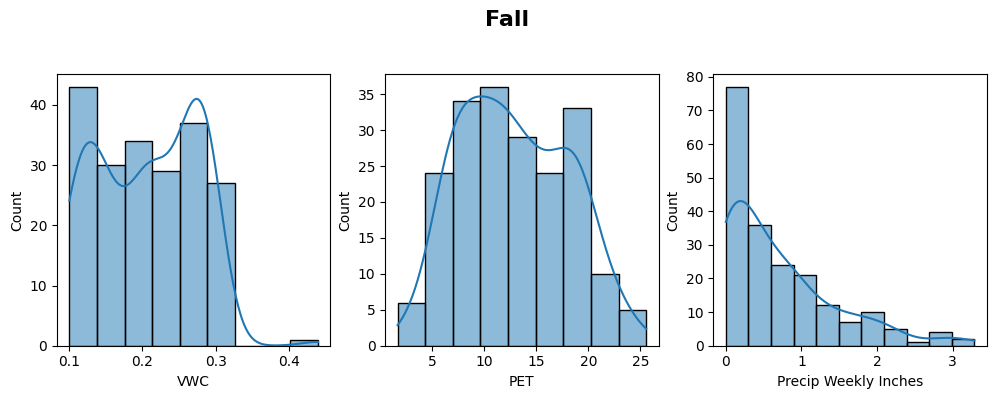

In [34]:
""" Fall:
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(fall_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(fall_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(fall_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Fall', ha='center', fontsize=16, weight='bold')

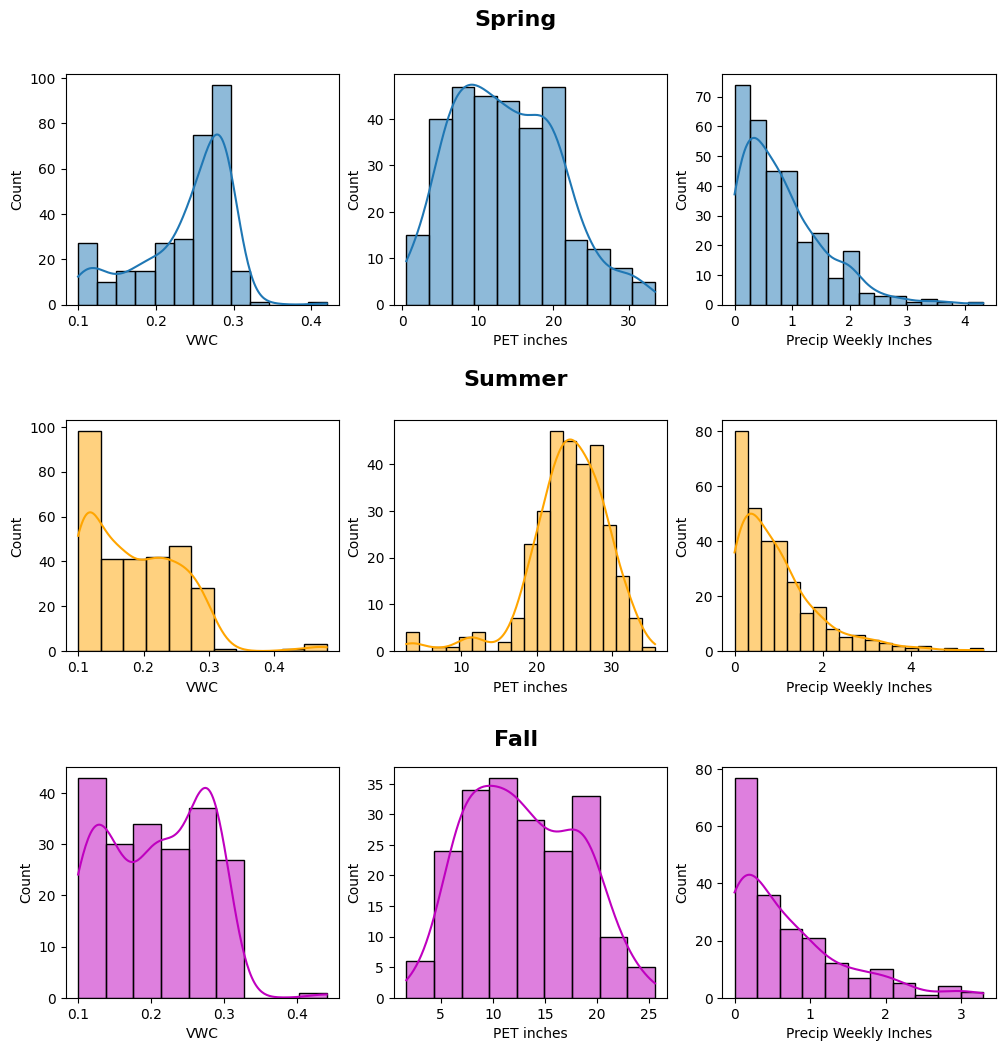

In [35]:
""" Makes 9 graphs putting putting the Spring, Summr and Fall graphs."""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(spring_weekly, x = "vwc", kde = True, ax = ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(spring_weekly, x = "pet", kde = True, ax = ax2)
ax2.set_xlabel("PET inches")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(spring_weekly_clean, x = "precip", kde = True, ax = ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Spring', ha = 'center', fontsize = 16, weight = 'bold')

# Summer
ax4 = fig.add_subplot(gs[1, 0])
sns.histplot(summer_weekly, x = "vwc", color = 'orange', kde = True, ax = ax4)
ax4.set_xlabel("VWC")

ax5 = fig.add_subplot(gs[1, 1])
sns.histplot(summer_weekly, x = "pet", color = 'orange', kde = True, ax = ax5)
ax5.set_xlabel("PET inches")

ax6 = fig.add_subplot(gs[1, 2])
sns.histplot(summer_weekly_clean, x = "precip", color = 'orange', kde = True, ax = ax6)
ax6.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.62, 'Summer', ha = 'center', fontsize = 16, weight = 'bold')

# Fall
ax7 = fig.add_subplot(gs[2, 0])
sns.histplot(fall_weekly, x = "vwc", color = 'm', kde = True, ax = ax7)
ax7.set_xlabel("VWC")

ax8 = fig.add_subplot(gs[2, 1])
sns.histplot(fall_weekly, x = "pet", color = 'm', kde = True, ax = ax8)
ax8.set_xlabel("PET inches")

ax9 = fig.add_subplot(gs[2, 2])
sns.histplot(fall_weekly_clean, x="precip", color = 'm', kde = True, ax = ax9)
ax9.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.32, 'Fall', ha = 'center', fontsize = 16, weight = 'bold')
plt.subplots_adjust(hspace = 0.5)
plt.show()



Spring mean:13.652929627948435 and std:6.9538600140000435
Summer mean:23.433054347472808 and std: 6.152511365165081
Fall mean:12.054651246591556 and std:5.669408800602921


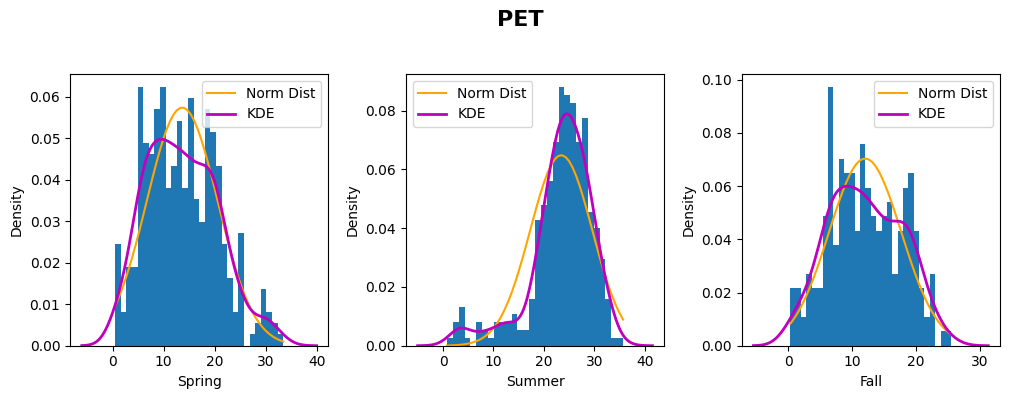

In [36]:
# Normal Fit to ithaca PET Spring, Summer and Fall
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
axs1 = fig.add_subplot(gs[0, 0])
spring_weekly_pet_arr = np.array(spring_weekly_pet, dtype=np.float64)
spring_weekly_pet_arr = spring_weekly_pet_arr[np.isfinite(spring_weekly_pet_arr)]
axs1.hist(spring_weekly_pet_arr, bins = 30, density=True)
[sp_mean_fit, sp_std_fit] = scipy.stats.norm.fit(spring_weekly_pet_arr)
sp_x = np.linspace(np.min(spring_weekly_pet_arr), np.max(spring_weekly_pet_arr),)
sp_norm =  scipy.stats.norm.pdf(sp_x, sp_mean_fit, sp_std_fit)
axs1.plot(sp_x, sp_norm, color='orange', label = 'Norm Dist')
sns.kdeplot(spring_weekly_pet_arr, ax=axs1, color='m', linewidth=2, label='KDE')
axs1.set_xlabel("Spring")
axs1.legend()
print(f'Spring mean:{sp_mean_fit} and std:{sp_std_fit}')

# Summer
axs2 = fig.add_subplot(gs[0, 1])
summer_weekly_pet_arr = np.array(summer_weekly_pet, dtype=np.float64)
summer_weekly_pet_arr = summer_weekly_pet_arr[np.isfinite(summer_weekly_pet_arr)]
axs2.hist(summer_weekly_pet_arr,bins = 30, density=True)
sum_mean_fit, sum_std_fit = scipy.stats.norm.fit(summer_weekly_pet_arr)
sum_x = np.linspace(np.min(summer_weekly_pet_arr), np.max(summer_weekly_pet_arr),)
axs2.plot(sum_x, scipy.stats.norm.pdf(sum_x, sum_mean_fit, sum_std_fit), color='orange', label = 'Norm Dist')
sns.kdeplot(summer_weekly_pet_arr, ax=axs2, color='m', linewidth=2, label='KDE')
axs2.set_xlabel("Summer")
axs2.legend()
print(f'Summer mean:{sum_mean_fit} and std: {sum_std_fit}')

# Fall
axs3 = fig.add_subplot(gs[0, 2])
fall_weekly_pet_arr = np.array(fall_weekly_pet, dtype=np.float64)
fall_weekly_pet_arr = fall_weekly_pet_arr[np.isfinite(fall_weekly_pet_arr)]
axs3.hist(fall_weekly_pet_arr, bins = 30, density=True)
fall_mean_fit, fall_std_fit = scipy.stats.norm.fit(fall_weekly_pet_arr)
fall_x = np.linspace(np.min(fall_weekly_pet_arr), np.max(fall_weekly_pet_arr),)
axs3.plot(fall_x, scipy.stats.norm.pdf(fall_x, fall_mean_fit, fall_std_fit), color='orange', label = 'Norm Dist')
sns.kdeplot(fall_weekly_pet_arr, ax=axs3, color='m', linewidth=2, label='KDE')
axs3.set_xlabel("Fall")
axs3.legend()
print(f'Fall mean:{fall_mean_fit} and std:{fall_std_fit}')

fig.text(0.5, 0.92, 'PET', ha = 'center', fontsize = 16, weight = 'bold')
plt.subplots_adjust(wspace = 0.3)


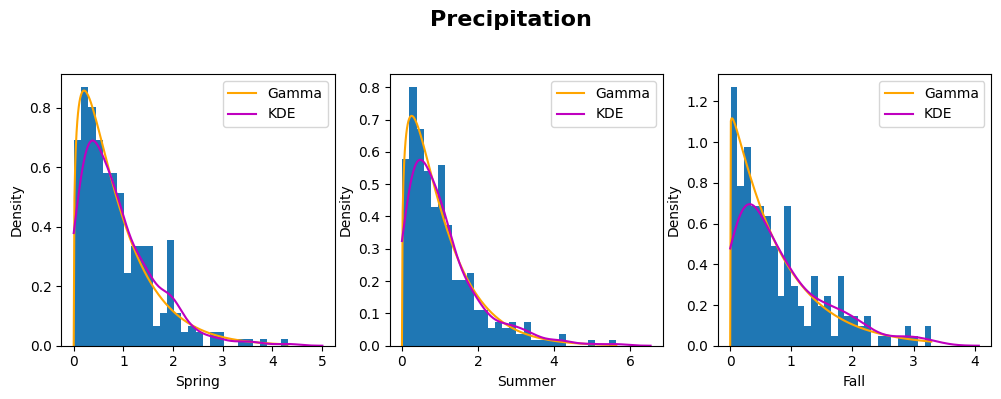

In [37]:
# Precip Gamma Distribution

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
axs1 = fig.add_subplot(gs[0, 0])
spring_weekly_precip_arr = np.array(spring_weekly_precip, dtype=np.float64)
spring_weekly_precip_arr = spring_weekly_precip_arr[np.isfinite(spring_weekly_precip_arr)]
spring_weekly_precip_arr = spring_weekly_precip_arr[spring_weekly_precip_arr > 0]
spring_weekly_precip_arr = spring_weekly_precip_arr[spring_weekly_precip_arr < 1000]
axs1.hist(spring_weekly_precip_arr, bins=30, density=True)
[sp_a_fit, sp_loc_fit, sp_scale_fit] = scipy.stats.gamma.fit(spring_weekly_precip_arr, floc=0)
sp_x = np.linspace(0, np.max(spring_weekly_precip_arr),300)
sp_gamma =  scipy.stats.gamma.pdf(sp_x, sp_a_fit, loc = sp_loc_fit, scale = sp_scale_fit)
axs1.plot(sp_x, sp_gamma, color='orange', label = 'Gamma')
sns.kdeplot(spring_weekly_precip_arr, ax=axs1, color='m', label='KDE', clip=(0, None))
axs1.set_xlabel("Spring")
axs1.legend()
fig.text(0.5, 0.92, 'Precipitation', ha = 'center', fontsize = 16, weight = 'bold')

# Summer
axs2 = fig.add_subplot(gs[0, 1])
summer_weekly_precip_arr = np.array(summer_weekly_precip, dtype=np.float64)
summer_weekly_precip_arr = summer_weekly_precip_arr[np.isfinite(summer_weekly_precip_arr)]
summer_weekly_precip_arr = summer_weekly_precip_arr[summer_weekly_precip_arr > 0]
summer_weekly_precip_arr = summer_weekly_precip_arr[summer_weekly_precip_arr < 1000]
axs2.hist(summer_weekly_precip_arr, bins=30, density=True)
[sum_a_fit, sum_loc_fit, sum_scale_fit] = scipy.stats.gamma.fit(summer_weekly_precip_arr, floc=0)
sum_x = np.linspace(0, np.max(summer_weekly_precip_arr),300)
sum_gamma =  scipy.stats.gamma.pdf(sum_x, sum_a_fit, loc = sum_loc_fit, scale = sum_scale_fit)
axs2.plot(sum_x, sum_gamma, color='orange', label = 'Gamma')
sns.kdeplot(summer_weekly_precip_arr, ax=axs2, color='m', label='KDE', clip=(0, None))
axs2.set_xlabel("Summer")
axs2.legend()

# Fall
axs3 = fig.add_subplot(gs[0, 2])
fall_weekly_precip_arr = np.array(fall_weekly_precip, dtype=np.float64)
fall_weekly_precip_arr = fall_weekly_precip_arr[np.isfinite(fall_weekly_precip_arr)]
fall_weekly_precip_arr = fall_weekly_precip_arr[fall_weekly_precip_arr > 0]
fall_weekly_precip_arr = fall_weekly_precip_arr[fall_weekly_precip_arr < 1000]
axs3.hist(fall_weekly_precip_arr, bins=30, density=True)
[fall_a_fit, fall_loc_fit, fall_scale_fit] = scipy.stats.gamma.fit(fall_weekly_precip_arr, floc=0)
fall_x = np.linspace(0, np.max(fall_weekly_precip_arr),300)
fall_gamma =  scipy.stats.gamma.pdf(fall_x, fall_a_fit, loc = fall_loc_fit, scale = fall_scale_fit)
axs3.plot(fall_x, fall_gamma, color='orange', label = 'Gamma')
sns.kdeplot(fall_weekly_precip_arr, ax=axs3, color='m', label='KDE', clip=(0, None))
axs3.set_xlabel("Fall")
axs3.legend()



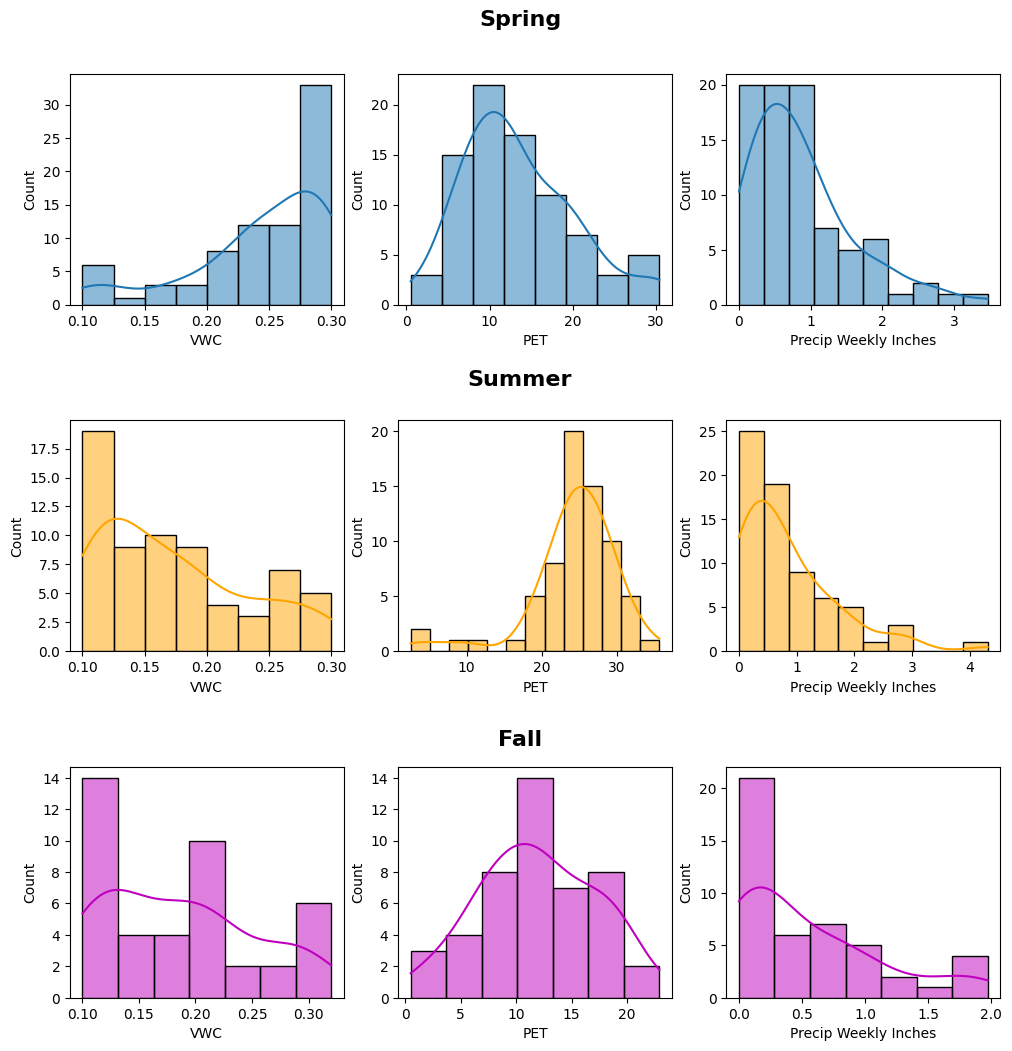


        No Drought vwc value: 0.28, 
        Abnormally Dry vwc value: 0.27, 
        Moderate Drought vwc value:0.25, 
        Severe Drought vwc value: 0.24, 
        Extreme Drought vwc value: 0.24, 
        Exceptional Drought vwc value: 0.24

        No Drought vwc value: 0.19, 
        Abnormally Dry vwc value: 0.17, 
        Moderate Drought vwc value:0.16, 
        Severe Drought vwc value: 0.14, 
        Extreme Drought vwc value: 0.13, 
        Exceptional Drought vwc value: 0.13

        No Drought vwc value: 0.21, 
        Abnormally Dry vwc value: 0.2, 
        Moderate Drought vwc value:0.18, 
        Severe Drought vwc value: 0.15400000000000003, 
        Extreme Drought vwc value: 0.14350000000000002, 
        Exceptional Drought vwc value: 0.13

        No Drought pet value: 17.85833537451923, 
        Abnormally Dry pet value: 18.320877873618155, 
        Moderate Drought pet value:19.007109608352184, 
        Severe Drought pet value: 20.370142174661158, 
        Ex

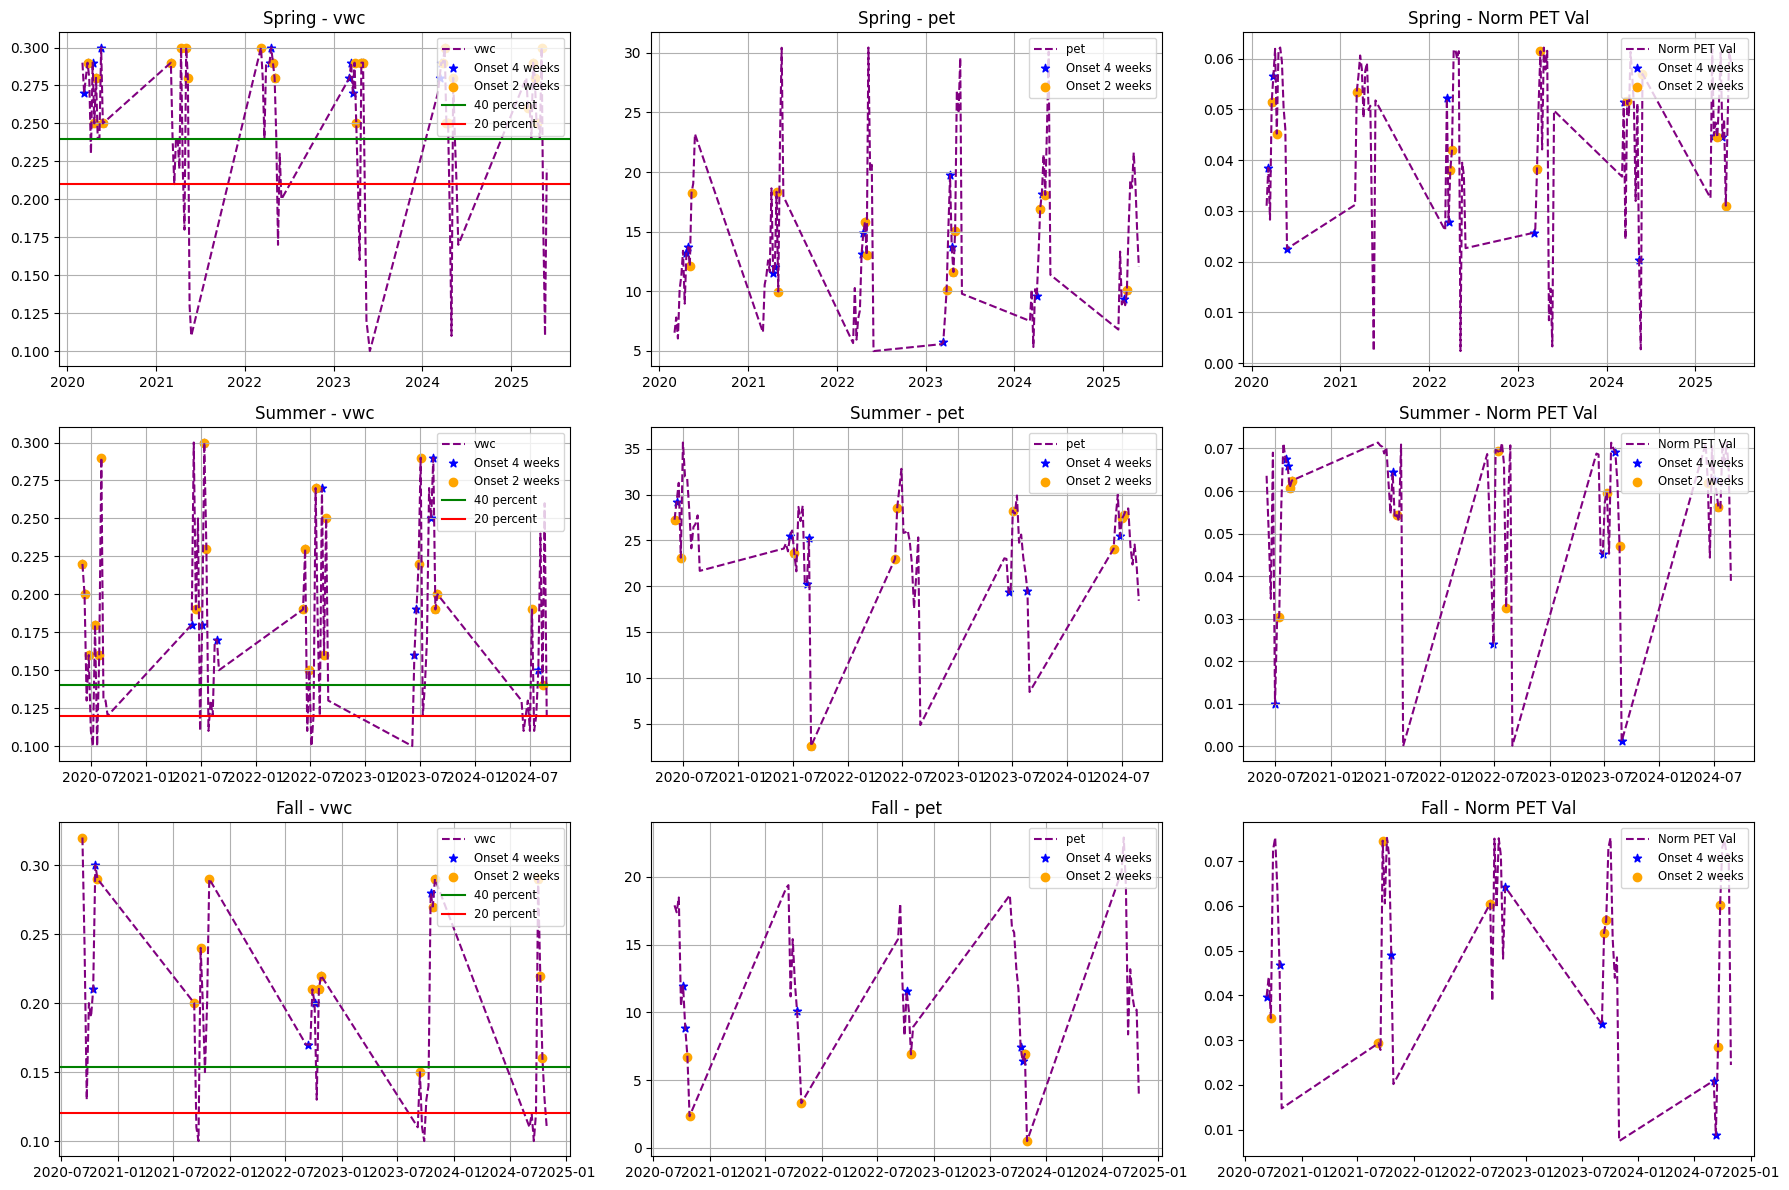

In [2]:
import sys
sys.path.append('/Users/adriennekirk/Desktop/Flash Droughts/') 
from FlashDroughts import KDEhistogram 
from FlashDroughts import DroughtDetection
lat = 40.77
lon = -81.22
kde = KDEhistogram(sdate='2020-03-01', edate='2025-05-31', lat=lat, lon=lon)
kde.kde_histogram()

drought = DroughtDetection(sdate='2020-03-01', edate='2025-05-31', lat=lat, lon=lon)
drought.pet_curve('spring')
drought.pet_curve('summer')
drought.pet_curve('fall')
p_vwc = [70, 55, 50, 40, 35, 30]
p_pet = [70, 75, 80, 85, 90, 95]
# VWC
drought.categorize(*p_vwc, 'spring', 'vwc')
drought.categorize(*p_vwc, 'summer', 'vwc')
drought.categorize(*p_vwc, 'fall', 'vwc')

# PET
drought.categorize(*p_pet, 'spring', 'pet')
drought.categorize(*p_pet, 'summer', 'pet')
drought.categorize(*p_pet, 'fall', 'pet')

# Normalized PET
drought.categorize(*p_pet, 'spring', 'Norm PET Val')
drought.categorize(*p_pet, 'summer', 'Norm PET Val')
drought.categorize(*p_pet, 'fall', 'Norm PET Val')

drought.full_plot()